In [1]:
import os
import cv2
import numpy as np
from moviepy.editor import VideoFileClip
from tqdm.notebook import tqdm
from typing import List, Tuple, Dict, Union
import matplotlib.pyplot as plt
import pickle as pkl

# Preprocessing Data

In [2]:
dataset_path = 'Shop DataSet/'
non_shop_lifters_path = os.path.join(dataset_path, 'non shop lifters')
shop_lifters_path = os.path.join(dataset_path, 'shop lifters')


In [3]:
len(os.listdir(non_shop_lifters_path)), len(os.listdir(shop_lifters_path))

(531, 324)

In [35]:
def get_frame_rate(video_path):
    # Open the video file
    video = cv2.VideoCapture(video_path)
    
    # Check if the video was opened successfully
    if not video.isOpened():
        print(f"Error: Cannot open video file {video_path}")
        return None
    
    # Get the frame rate
    fps = video.get(cv2.CAP_PROP_FPS)
    
    # Release the video object
    video.release()
    
    return fps

In [40]:
get_frame_rate('./Shop DataSet/non shop lifters/shop_lifter_n_1.mp4')

25.0

In [39]:
get_frame_rate('./Shop DataSet/shop lifters/shop_lifter_10.mp4')

24.75

In [5]:
def process_and_extract_frames(
        dataset_path: str, 
        new_dir_path: str='./Shop DataSet/preprocessed_data', 
        target_shape: Tuple[int,int]=(224,224),
        sample_rate: int=1):
    """
    Processes and extracts frames from videos in the dataset path.

    Parameters:
    - dataset_path (str): Path to the folder containing video files.
    - new_dir_path (str): Path to save the processed .npy files. Default is './Shop DataSet/preprocessed_data'.
    - target_shape (tuple): Desired frame size for resizing. Default is (224, 224).
    - sample_rate (int): Interval to sample frames. Default is 1 (every frame).

    """
    new_path = os.path.join(new_dir_path, dataset_path.split('/')[-1])
    os.makedirs(new_path, exist_ok=True)
    for video in tqdm(os.listdir(dataset_path)):
        video_path = os.path.join(dataset_path, video)
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_count % sample_rate == 0:
                frame = cv2.resize(frame, target_shape)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            frame_count += 1
        cap.release()
        frames = np.array(frames)
        output_filename = f"{video.split('.')[0]}.pkl"
        # np.savez_compressed(os.path.join(new_path, output_filename), frames)
        # save as pkl file
        pkl.dump(frames, open(os.path.join(new_path, output_filename), 'wb'))


In [11]:
process_and_extract_frames(shop_lifters_path)

  0%|          | 0/324 [00:00<?, ?it/s]

In [12]:
process_and_extract_frames(non_shop_lifters_path)

  0%|          | 0/531 [00:00<?, ?it/s]

In [16]:
sample_video = pkl.load(open('./Shop DataSet/preprocessed_data/shop lifters/shop_lifter_0.pkl', 'rb'))
sample_video.shape

(322, 224, 224, 3)

In [21]:
def get_seq_len(dataset_path: str) -> Tuple[int,int]:
    min_seq_len = float('inf')
    max_seq_len = float('-inf')
    all_seq_len = []
    for video_path in tqdm(os.listdir(dataset_path)):
        video = pkl.load(open(os.path.join(dataset_path, video_path), 'rb'))
        min_seq_len = min(min_seq_len, video.shape[0])
        max_seq_len = max(max_seq_len, video.shape[0])
        all_seq_len.append(video.shape[0])
    return min_seq_len, max_seq_len, all_seq_len

In [22]:
min_sl_seq_len, max_sl_seq_len, all_sl_seq_len = get_seq_len('./Shop DataSet/preprocessed_data/shop lifters')

  0%|          | 0/324 [00:00<?, ?it/s]

In [23]:
min_sl_seq_len, max_sl_seq_len

(100, 570)

In [24]:
min_nsl_seq_len, max_nsl_seq_len, all_nsl_seq_len = get_seq_len('./Shop DataSet/preprocessed_data/non shop lifters')

  0%|          | 0/531 [00:00<?, ?it/s]

In [25]:
min_nsl_seq_len, max_nsl_seq_len

(75, 1850)

In [26]:
all_seq_len = all_sl_seq_len + all_nsl_seq_len
all_seq_len = np.array(all_seq_len)

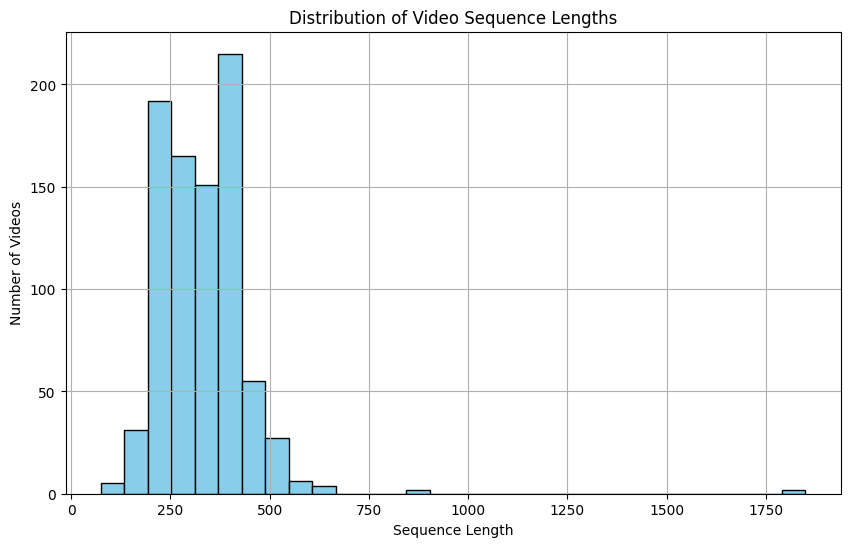

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(all_seq_len, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Video Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Number of Videos')
plt.grid(True)
plt.show()

In [28]:
all_seq_len.min(), all_seq_len.max()

(75, 1850)

In [29]:
np.percentile(a=all_seq_len, q=97)

500.0

# Prepare Dataset

In [1]:
from sklearn.model_selection import train_test_split
import os
shop_lifter_pkl = os.listdir('./Shop DataSet/preprocessed_data/shop lifters')
non_shop_lifter_pkl = os.listdir('./Shop DataSet/preprocessed_data/non shop lifters')
non_shop_lifter_pkl = [file for file in non_shop_lifter_pkl if ('_1' not in file) or (file == 'shop_lifter_n_1.pkl')]

shop_lifter_pkl = [f'./Shop DataSet/preprocessed_data/shop lifters/{file}' for file in shop_lifter_pkl]
non_shop_lifter_pkl = [f'./Shop DataSet/preprocessed_data/non shop lifters/{file}' for file in non_shop_lifter_pkl]

all_pkl = shop_lifter_pkl + non_shop_lifter_pkl
labels = [1] * len(shop_lifter_pkl) + [0] * len(non_shop_lifter_pkl)

train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_pkl, labels, test_size=0.15, random_state=42, shuffle=True, stratify=labels
)

# Split the temporary set into validation and test set with stratification
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=42, shuffle=True, stratify=temp_labels
)

# Print the count of each class in each set for verification
print(f'Training set: {len(train_files)} files, {sum(train_labels)} shop lifters, {len(train_labels) - sum(train_labels)} non-shop lifters')
print(f'Validation set: {len(val_files)} files, {sum(val_labels)} shop lifters, {len(val_labels) - sum(val_labels)} non-shop lifters')
print(f'Test set: {len(test_files)} files, {sum(test_labels)} shop lifters, {len(test_labels) - sum(test_labels)} non-shop lifters')

Training set: 439 files, 275 shop lifters, 164 non-shop lifters
Validation set: 39 files, 25 shop lifters, 14 non-shop lifters
Test set: 39 files, 24 shop lifters, 15 non-shop lifters


In [2]:
import numpy as np
from sklearn.utils import resample

# Separate the training files and labels into the two classes
shop_lifter_train = [file for file, label in zip(train_files, train_labels) if label == 1]
non_shop_lifter_train = [file for file, label in zip(train_files, train_labels) if label == 0]

# Undersample the non-shop lifters to match the number of shop lifters
shop_lifter_train_balanced = resample(shop_lifter_train,
                                          replace=False,
                                          n_samples=len(non_shop_lifter_train),
                                          random_state=42)

# Combine the balanced datasets
train_files_balanced = shop_lifter_train_balanced + non_shop_lifter_train
train_files_balanced = np.array(train_files_balanced)
shuffled_indices = np.random.permutation(len(train_files_balanced))
train_files_balanced = train_files_balanced[shuffled_indices].tolist()

# Print the balanced training set counts
print(f'Balanced Training set: {len(train_files_balanced)} files, '
      f'{len(shop_lifter_train_balanced)} shop lifters, '
      f'{len(non_shop_lifter_train)} non-shop lifters')


Balanced Training set: 328 files, 164 shop lifters, 164 non-shop lifters


In [3]:
len(shop_lifter_pkl), len(non_shop_lifter_pkl)

(324, 193)

In [4]:
len(train_files_balanced), len(val_files), len(test_files)

(328, 39, 39)

In [5]:
from typing import List, Dict
def get_sl_and_nsl(files: List[str]) -> Dict[int,int]:
    sl = 0
    nsl = 0
    for f in files:
        if 'non shop lifters' in f:
            nsl += 1
        else:
            sl += 1
    print(f'Shop Lifters: {sl}, Non Shop Lifters: {nsl}')
    return {
        0: nsl,
        1: sl
    }

In [6]:
_ = get_sl_and_nsl(train_files_balanced)

Shop Lifters: 164, Non Shop Lifters: 164


In [7]:
_ = get_sl_and_nsl(test_files)

Shop Lifters: 24, Non Shop Lifters: 15


In [8]:
_ = get_sl_and_nsl(val_files)

Shop Lifters: 25, Non Shop Lifters: 14


In [9]:
def calculate_class_weights(files: List[str]) -> Dict[int, float]:
    class_weights = {}
    class_count = get_sl_and_nsl(files)
    total_samples = sum(class_count.values())
    for cls, count in class_count.items():
        class_weights[cls] = total_samples / count
    normalized_class_weights = {}
    sum_class_weights = sum(class_weights.values())
    for cls, weight in class_weights.items():
        normalized_class_weights[cls] = weight / sum_class_weights
    return class_weights, normalized_class_weights

In [10]:
train_class_weights, normalized_class_weights = calculate_class_weights(train_files_balanced)

Shop Lifters: 164, Non Shop Lifters: 164


In [11]:
train_class_weights, normalized_class_weights

({0: 2.0, 1: 2.0}, {0: 0.5, 1: 0.5})

In [12]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import pickle as pkl
import random
import numpy as np
from PIL import Image
from typing import Tuple, List, Dict


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

class VideoDataset(Dataset):
    def __init__(self, video_files: List[str], max_seq_length: float=500, sampling_interval: int=2, type: str='train', seed: int=42, target_shape: Tuple[int,int]=(224,224)):
        self.video_files = video_files
        self.max_seq_length = max_seq_length
        self.sampling_interval = sampling_interval
        self.type = type
        self.seed = seed
        self.adjusted_max_seq_len = int(self.max_seq_length/self.sampling_interval)
        self.transform = T.Compose([
            T.Resize(target_shape),
            T.Lambda(lambda x: np.array(x, dtype=np.float32) / 255.0),
            T.ToTensor()
        ])
        if type=='train':
            self.augment_transforms = T.Compose([
                T.RandomHorizontalFlip(),
                T.RandomRotation(10),
                T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                T.RandomResizedCrop(size=target_shape, scale=(0.8, 1.0)),
            ])
        
    def __len__(self):
        return len(self.video_files)
    
    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        video = pkl.load(open(video_path, 'rb'))
        video = [Image.fromarray(frame.astype('uint8')) for frame in video]
        label = 0. if 'non shop lifters' in video_path else 1.
        set_seed(self.seed + idx)
        if self.transform:
            video = [self.transform(frame) for frame in video]

        if self.type == 'train':
            video = [self.augment_transforms(frame) for frame in video]
        
        video = torch.stack(video)
        # print(video.dtype)
        # Apply frame sampling here by skipping every other frame
        video = video[::self.sampling_interval]

        # Truncate or pad the sequence to max_seq_length
        if len(video) > self.adjusted_max_seq_len:
            video = video[:self.adjusted_max_seq_len]
        else:
            padding = torch.zeros(self.adjusted_max_seq_len - len(video), *video.shape[1:])
            video = torch.cat((video, padding), axis=0)
            
        
        return video , label


In [13]:
target_shape = (64,64)
train_dataset = VideoDataset(train_files_balanced, type='train', target_shape=target_shape, sampling_interval=25)
val_dataset = VideoDataset(val_files, type='val', target_shape=target_shape, sampling_interval=25)
test_dataset = VideoDataset(test_files, type='test', target_shape=target_shape, sampling_interval=25)

In [14]:
for x in train_dataset:
    print(x[0].shape, x[1])
    break

torch.Size([20, 3, 64, 64]) 0.0


In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=8)
val_dataloader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [16]:
for x in train_dataloader:
    print(x[0].shape, x[1])
    break

torch.Size([8, 20, 3, 64, 64]) tensor([0., 0., 0., 0., 0., 0., 1., 1.], dtype=torch.float64)


# Model

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv3DLSTMModel(nn.Module):
    def __init__(self, num_classes: int=1, hidden_size: int=256, lstm_layers: int=1, bidirectional: bool=False, vid_shape: Tuple[int,int,int]=(25,*target_shape)):
        super(Conv3DLSTMModel, self).__init__()
        
        # Conv3D block
        self.conv3d_block = nn.Sequential(
            nn.Conv3d(in_channels=3, out_channels=32, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool3d(kernel_size=(1, 2, 2)), 
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool3d(kernel_size=(1, 2, 2)),
            nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),  
        )
        self._calculate_spatial_dims(input_shape=(3, *vid_shape))
        # LSTM block
        self.lstm = nn.LSTM(input_size=self.lstm_input_size,  
                            hidden_size=hidden_size,
                            num_layers=lstm_layers,
                            batch_first=True,
                            bidirectional=bidirectional)
        
        # Fully connected layer
        lstm_output_size = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(lstm_output_size, 512)
        self.classifier = nn.Linear(512, num_classes)
    
    def _calculate_spatial_dims(self, input_shape):
        """Calculate the spatial dimensions after Conv3D and pooling layers."""
        x = torch.zeros(1, *input_shape)  # Create a dummy tensor to pass through Conv3D block
        x = self.conv3d_block(x)
        _, _, t, h, w = x.size()  # Get the output shape
        self.lstm_input_size = 128 * h * w  # Update LSTM input size
        # print(f"Adjusted LSTM input size: {self.lstm_input_size}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, channels, height, width = x.size()
        
        # Apply Conv3D block
        x = x.permute(0, 2, 1, 3, 4)  # (batch_size, channels, seq_len, height, width)
        x = self.conv3d_block(x)  # (batch_size, 128, new_seq_len, new_height, new_width)
        
        # Prepare for LSTM: flatten spatial dimensions
        x = x.view(batch_size, x.size(2), -1)  # (batch_size, new_seq_len, 128*new_height*new_width)
        
        # Apply LSTM
        lstm_out, _ = self.lstm(x)  # (batch_size, new_seq_len, hidden_size)
        
        # Get the output from the last time step
        last_output_layer = lstm_out[:, -1, :]  # (batch_size, hidden_size)
        
        # Fully connected layer
        output = F.relu(self.fc(last_output_layer))  # (batch_size, 512)
        output = self.classifier(output)  # (batch_size, num_classes)
        
        return output

# Example usage:
model = Conv3DLSTMModel(num_classes=1)
print(model)

# Check output with dummy input
dummy_input = torch.randn(4, 25, 3, 64, 64)
output = model(dummy_input)
print(output.shape)


Conv3DLSTMModel(
  (conv3d_block): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(8192, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=512, bias=True)
  (classifier): Linear(in_features=512, out_features=1, bias=True)
)
torch.Size([4, 1])


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv3DModel(nn.Module):
    def __init__(self, num_classes: int=1, vid_shape: Tuple[int,int,int]=(25,*target_shape)):
        super(Conv3DModel, self).__init__()
        
        # Conv3D block
        self.conv3d_block = nn.Sequential(
            nn.Conv3d(in_channels=3, out_channels=32, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool3d(kernel_size=(1, 2, 2)), 
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool3d(kernel_size=(1, 2, 2)),
            nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),  
        )
        self._calculate_spatial_dims(input_shape=(3, *vid_shape))
        
        self.fc = nn.Linear(self.conv3d_output_size, 512)
        self.classifier = nn.Linear(512, num_classes)
    
    def _calculate_spatial_dims(self, input_shape):
        """Calculate the spatial dimensions after Conv3D and pooling layers."""
        x = torch.zeros(1, *input_shape)  # Create a dummy tensor to pass through Conv3D block
        x = self.conv3d_block(x)
        _, _, t, h, w = x.size()  # Get the output shape
        self.conv3d_output_size = t * 128 * h * w 

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        x = x.permute(0, 2, 1, 3, 4)  # (batch_size, channels, seq_len, height, width)
        x = self.conv3d_block(x)  # (batch_size, 128, new_seq_len, new_height, new_width)
        
        x = nn.Flatten()(x) # (batch_size, new_seq_len*128*new_height*new_width)

        output = F.relu(self.fc(x))  # (batch_size, 512)
        output = self.classifier(output)  # (batch_size, num_classes)
        
        return output

# Example usage:
model = Conv3DModel(num_classes=1)
print(model)

# Check output with dummy input
dummy_input = torch.randn(4, 25, 3, 64, 64)
output = model(dummy_input)
print(output.shape)


Conv3DModel(
  (conv3d_block): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=98304, out_features=512, bias=True)
  (classifier): Linear(in_features=512, out_features=1, bias=True)
)
torch.Size([4, 1])


In [19]:
import torch

class SaveBestModel:
    def __init__(self, best_val_loss: float=float('inf'), save_path: str='../models_weights/best_model.pth'):
        self.best_val_loss = best_val_loss
        self.save_path = save_path

    def __call__(self, model: torch.nn.Module, current_val_loss: float, prev_best_min_loss: float):
        if current_val_loss < self.best_val_loss and current_val_loss < prev_best_min_loss:
            self.best_val_loss = current_val_loss
            torch.save(model, self.save_path)
            print(f'Best model saved with Val Loss: {self.best_val_loss:.4f}')


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score
def calculate_metrics(y_true: List[int], y_pred: List[int]) -> Tuple[float]:
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = 100 * np.sum(y_true == y_pred) / len(y_true)
    return accuracy, precision, recall, f1

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.utils
import torch.utils.data
from tqdm import tqdm
from typing import List, Tuple

def evaluate(
        dataloader: torch.utils.data.DataLoader, 
        model: torch.nn.Module, 
        criterion: torch.nn, 
        class_names: List[str]=None, 
        device: str="", 
        is_testing: bool=False
    ) -> Tuple[float]: 

    if device == "":
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    else:
        device = torch.device(device)

    model = model.to(device)
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            outputs = outputs.squeeze(-1)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            predicted = (torch.sigmoid(outputs) >= 0.5).long()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate average loss
    avg_loss = running_loss / len(dataloader)

    # Calculate evaluation metrics
    accuracy, precision, recall, f1 = calculate_metrics(np.array(all_labels), np.array(all_predictions))

    if is_testing:
        conf_matrix = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

        print(f'Average Loss: {avg_loss:.4f}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')

    return avg_loss, accuracy, precision, recall, f1


In [22]:
import torch
import numpy as np
import torch.utils
import torch.utils.data
from tqdm import tqdm


def train(
        model: torch.nn.Module, 
        train_loader: torch.utils.data.DataLoader, 
        val_loader: torch.utils.data.DataLoader, 
        criterion: torch.nn, 
        optimizer: torch.optim, 
        num_epochs: int=10, 
        device: str="", 
        start_epoch: int=0, 
        scheduler: torch.optim.lr_scheduler=None, 
        new_lr: float=None,
        models_weights_path: str='../models_weights/best_model.pth',
        prev_best_min_loss: float=float('inf'),
        prev_history: dict=None
    ) -> None:

    if device == "":
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model = torch.compile(model, backend="nvfuser")
    model = model.to(device)
    save_best_model = SaveBestModel(save_path=models_weights_path)
    if new_lr is not None:
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        all_labels = []
        all_predictions = []

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            outputs = outputs.squeeze(-1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            predicted = (torch.sigmoid(outputs) >= 0.5).long()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        avg_train_loss = running_loss / len(train_loader)

        train_losses.append(avg_train_loss)

        train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(np.array(all_labels), np.array(all_predictions))
        print(f'Train Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, '
              f'Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}')

        train_accuracies.append(train_accuracy)
        # Validation phase
        avg_val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate(val_loader, model, criterion)

        print(f'Val Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%, '
              f'Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}')
        print("-"*50)

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        # Save the best model using the callback
        save_best_model(model, avg_val_loss, prev_best_min_loss)

        # Step the scheduler if it exists
        if scheduler is not None:
            scheduler.step(avg_val_loss if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau) else None)
    print('Finished Training')
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies,
        "prev_best_min_loss": save_best_model.best_val_loss
    }
    if prev_history is not None:
        for key in prev_history.keys():
            if key != 'prev_best_min_loss':
                history[key] =  prev_history[key] + history[key]
    return history

In [23]:
import torch.optim as optim

vid_shape = (20,*target_shape)
model = Conv3DModel(num_classes=1, vid_shape=vid_shape)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# train_class_weights, normalized_class_weights = calculate_class_weights(train_files)
# pos_weight = torch.tensor([train_class_weights[1]],dtype=torch.float32).to(device)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

history = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10, models_weights_path='./models_weights/conv3d/best_model.pth')

Epoch 1/10
----------


100%|██████████| 41/41 [03:06<00:00,  4.55s/it]


Train Loss: 1.0018, Accuracy: 60.67%, Precision: 0.6070, Recall: 0.6067, F1 Score: 0.6064


100%|██████████| 39/39 [00:03<00:00, 11.36it/s]
c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 0.6638, Accuracy: 64.10%, Precision: 0.4109, Recall: 0.6410, F1 Score: 0.5008
--------------------------------------------------
Best model saved with Val Loss: 0.6638
Epoch 2/10
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


Train Loss: 0.6826, Accuracy: 59.76%, Precision: 0.5978, Recall: 0.5976, F1 Score: 0.5973


100%|██████████| 39/39 [00:03<00:00, 11.22it/s]


Val Loss: 0.6133, Accuracy: 64.10%, Precision: 0.6216, Recall: 0.6410, F1 Score: 0.6244
--------------------------------------------------
Best model saved with Val Loss: 0.6133
Epoch 3/10
----------


100%|██████████| 41/41 [03:16<00:00,  4.78s/it]


Train Loss: 0.6855, Accuracy: 57.93%, Precision: 0.5793, Recall: 0.5793, F1 Score: 0.5793


100%|██████████| 39/39 [00:03<00:00, 10.12it/s]


Val Loss: 0.6583, Accuracy: 61.54%, Precision: 0.6695, Recall: 0.6154, F1 Score: 0.6225
--------------------------------------------------
Epoch 4/10
----------


100%|██████████| 41/41 [03:13<00:00,  4.72s/it]


Train Loss: 0.6789, Accuracy: 57.32%, Precision: 0.5754, Recall: 0.5732, F1 Score: 0.5700


100%|██████████| 39/39 [00:03<00:00, 10.36it/s]


Val Loss: 0.6941, Accuracy: 51.28%, Precision: 0.7114, Recall: 0.5128, F1 Score: 0.4794
--------------------------------------------------
Epoch 5/10
----------


100%|██████████| 41/41 [03:12<00:00,  4.71s/it]


Train Loss: 0.6769, Accuracy: 57.62%, Precision: 0.5894, Recall: 0.5762, F1 Score: 0.5600


100%|██████████| 39/39 [00:04<00:00,  9.75it/s]


Val Loss: 0.6365, Accuracy: 66.67%, Precision: 0.7018, Recall: 0.6667, F1 Score: 0.6734
--------------------------------------------------
Epoch 6/10
----------


100%|██████████| 41/41 [03:13<00:00,  4.72s/it]


Train Loss: 0.6678, Accuracy: 62.20%, Precision: 0.6224, Recall: 0.6220, F1 Score: 0.6216


100%|██████████| 39/39 [00:03<00:00, 10.28it/s]


Val Loss: 0.6500, Accuracy: 61.54%, Precision: 0.6695, Recall: 0.6154, F1 Score: 0.6225
--------------------------------------------------
Epoch 7/10
----------


100%|██████████| 41/41 [03:15<00:00,  4.78s/it]


Train Loss: 0.6721, Accuracy: 63.41%, Precision: 0.6382, Recall: 0.6341, F1 Score: 0.6315


100%|██████████| 39/39 [00:03<00:00, 10.18it/s]


Val Loss: 0.6091, Accuracy: 71.79%, Precision: 0.7140, Recall: 0.7179, F1 Score: 0.7155
--------------------------------------------------
Best model saved with Val Loss: 0.6091
Epoch 8/10
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


Train Loss: 0.6631, Accuracy: 61.89%, Precision: 0.6202, Recall: 0.6189, F1 Score: 0.6179


100%|██████████| 39/39 [00:03<00:00, 12.45it/s]


Val Loss: 0.6324, Accuracy: 66.67%, Precision: 0.6722, Recall: 0.6667, F1 Score: 0.6690
--------------------------------------------------
Epoch 9/10
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


Train Loss: 0.6553, Accuracy: 60.06%, Precision: 0.6017, Recall: 0.6006, F1 Score: 0.5995


100%|██████████| 39/39 [00:03<00:00, 12.40it/s]


Val Loss: 0.6327, Accuracy: 66.67%, Precision: 0.6722, Recall: 0.6667, F1 Score: 0.6690
--------------------------------------------------
Epoch 10/10
----------


100%|██████████| 41/41 [03:06<00:00,  4.54s/it]


Train Loss: 0.6549, Accuracy: 62.20%, Precision: 0.6221, Recall: 0.6220, F1 Score: 0.6218


100%|██████████| 39/39 [00:03<00:00, 11.80it/s]

Val Loss: 0.6378, Accuracy: 66.67%, Precision: 0.6722, Recall: 0.6667, F1 Score: 0.6690
--------------------------------------------------
Finished Training


In [25]:
history

{'train_loss': [1.0018003398336743,
  0.6826147739945843,
  0.6855435281219643,
  0.6789035462751621,
  0.676856418214057,
  0.6677705000109244,
  0.6721103375823032,
  0.6631151535775421,
  0.6553310167453275,
  0.6548531680515536],
 'val_loss': [0.6637931342881459,
  0.6132773695847927,
  0.6583017471891183,
  0.6940851118893195,
  0.6364713399074017,
  0.650032367461767,
  0.6090658524861703,
  0.63237243050184,
  0.6327457047807865,
  0.6378330404941852],
 'train_accuracy': [60.670731707317074,
  59.75609756097561,
  57.926829268292686,
  57.31707317073171,
  57.6219512195122,
  62.19512195121951,
  63.41463414634146,
  61.890243902439025,
  60.0609756097561,
  62.19512195121951],
 'val_accuracy': [64.1025641025641,
  64.1025641025641,
  61.53846153846154,
  51.282051282051285,
  66.66666666666667,
  61.53846153846154,
  71.7948717948718,
  66.66666666666667,
  66.66666666666667,
  66.66666666666667],
 'prev_best_min_loss': 0.6090658524861703}

C:\Users\001\AppData\Local\Temp\ipykernel_6228\1715951988.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_conv3d = torch.load('./models_weights/conv3d/best_model.pt

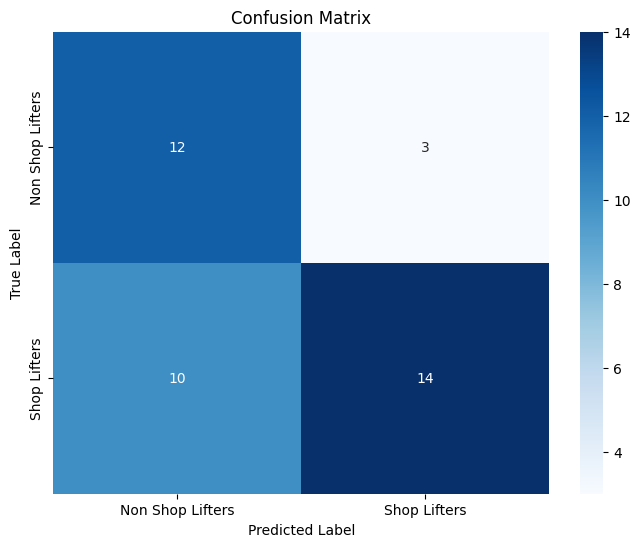

Average Loss: 0.6609
Accuracy: 66.6667
Precision: 0.7166
Recall: 0.6667
F1 Score: 0.6697


(0.6609021604825289,
 66.66666666666667,
 0.7165775401069518,
 0.6666666666666666,
 0.6697429136453525)

In [24]:
best_conv3d = torch.load('./models_weights/conv3d/best_model.pth')
evaluate(test_dataloader, best_conv3d, criterion, class_names=['Non Shop Lifters', 'Shop Lifters'], device='cuda', is_testing=True)